In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neural_network import MLPRegressor

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
import pandas as pd
housing_data1=pd.read_csv('gdrive/My Drive/HousingPrices.csv')

housing_data2=pd.read_csv('gdrive/My Drive/HousingPrices2021.csv')

In [7]:
housing_data_ = housing_data1[housing_data1['Year'] >= 2000]

In [8]:
housing_data1.describe

<bound method NDFrame.describe of     STATISTIC           Statistic Label  TLIST(A1)  Year C02343V02817  \
0     HSA06C1          New House Prices       1975  1975            -   
1     HSA06C1          New House Prices       1975  1975           01   
2     HSA06C1          New House Prices       1975  1975           02   
3     HSA06C1          New House Prices       1975  1975           03   
4     HSA06C1          New House Prices       1975  1975           04   
..        ...                       ...        ...   ...          ...   
583   HSA06C2  Second Hand House Prices       2016  2016           02   
584   HSA06C2  Second Hand House Prices       2016  2016           03   
585   HSA06C2  Second Hand House Prices       2016  2016           04   
586   HSA06C2  Second Hand House Prices       2016  2016           05   
587   HSA06C2  Second Hand House Prices       2016  2016           06   

            Area  UNIT     VALUE  
0       National  Euro   13254.0  
1         Dublin  Euro   13137.0  
2           Cork  Euro   12921.0  
3         Galway  Euro   14420.0  
4       Limerick  Euro   13594.0  
..           ...   ...       ...  
583         Cork  Euro  240683.0  
584       Galway  Euro  214645.0  
585     Limerick  Euro  192721.0  
586    Waterford  Euro  179609.0  
587  Other areas  Euro  201272.0  

[588 rows x 8 columns]>

In [9]:
housing_data1.shape

(588, 8)

In [10]:
housing_data2.shape

(476745, 9)

In [11]:
print(housing_data1.head())
print(housing_data2.head())

  STATISTIC   Statistic Label  TLIST(A1)  Year C02343V02817      Area  UNIT  \
0   HSA06C1  New House Prices       1975  1975            -  National  Euro   
1   HSA06C1  New House Prices       1975  1975           01    Dublin  Euro   
2   HSA06C1  New House Prices       1975  1975           02      Cork  Euro   
3   HSA06C1  New House Prices       1975  1975           03    Galway  Euro   
4   HSA06C1  New House Prices       1975  1975           04  Limerick  Euro   

     VALUE  
0  13254.0  
1  13137.0  
2  12921.0  
3  14420.0  
4  13594.0  
    SALE_DATE                                         ADDRESS POSTAL_CODE  \
0  2010-01-01          5 Braemor Drive, Churchtown, Co.Dublin         NaN   
1  2010-01-03  134 Ashewood Walk, Summerhill Lane, Portlaoise         NaN   
2  2010-01-04             1 Meadow Avenue, Dundrum, Dublin 14         NaN   
3  2010-01-04                         1 The Haven, Mornington         NaN   
4  2010-01-04                   11 Melville Heights, Kilkenny 

In [12]:
housing_data2['Year'] = pd.to_datetime(housing_data2['SALE_DATE']).dt.year

In [13]:
print("Mapping counties to areas...")
county_map = {
    'Dublin': 'Dublin',
    'Cork': 'Cork',
    'Galway': 'Galway',
    'Limerick': 'Limerick',
    'Waterford': 'Waterford',
    'Meath': 'Other areas',
    'Kildare': 'Other areas',
    'Wicklow': 'Other areas',
    'Laois': 'Other areas',
    'Kilkenny': 'Other areas'
}

Mapping counties to areas...


In [14]:
housing_data2['Area'] = housing_data2['COUNTY'].map(county_map)

In [15]:
housing_data2['Area'] = housing_data2['Area'].fillna('Other areas')

In [16]:
#Checking the property types between second hand or new houses
housing_data2['Statistic Label'] = 'Second Hand House Prices'
try:
    new_mask = housing_data2['PROPERTY_DESC'].str.contains('New', case=False)
    housing_data2.loc[new_mask, 'Statistic Label'] = 'New House Prices'
except:
    print("Warning: Couldn't determine all property types, some might be incorrect")



In [17]:
housing_data2.rename(columns={'SALE_PRICE': 'VALUE'}, inplace=True)

In [18]:
housing_data2_avg = housing_data2.groupby(['Year', 'Area', 'Statistic Label'])['VALUE'].mean().reset_index()


In [19]:
print("Aggregating transaction data...")
housing_data2_avg = housing_data2.groupby(['Year', 'Area', 'Statistic Label'])['VALUE'].mean().round(0).reset_index()


Aggregating transaction data...


In [20]:

housing_data2_avg['Property Type'] = housing_data2_avg['Statistic Label']



housing_data1_simple = housing_data1[['Year', 'Area', 'Statistic Label', 'VALUE']].copy()
housing_data1_simple.rename(columns={'Statistic Label': 'Property Type'}, inplace=True)

housing_data2_simple = housing_data2_avg[['Year', 'Area', 'Property Type', 'VALUE']].copy()

print("First dataset after simplification:")
print(housing_data1_simple.head())
print("Second dataset after simplification:")
print(housing_data2_simple.head())



First dataset after simplification:
   Year      Area     Property Type    VALUE
0  1975  National  New House Prices  13254.0
1  1975    Dublin  New House Prices  13137.0
2  1975      Cork  New House Prices  12921.0
3  1975    Galway  New House Prices  14420.0
4  1975  Limerick  New House Prices  13594.0
Second dataset after simplification:
   Year    Area             Property Type     VALUE
0  2010    Cork          New House Prices  248630.0
1  2010    Cork  Second Hand House Prices  224531.0
2  2010  Dublin          New House Prices  249783.0
3  2010  Dublin  Second Hand House Prices  352774.0
4  2010  Galway          New House Prices  207723.0


In [21]:
print("different the datasets are in the overlap years...")
data1_overlap = housing_data1_simple[(housing_data1_simple['Year'] >= 2010) & (housing_data1_simple['Year'] <= 2016)]
data2_overlap = housing_data2_simple[(housing_data2_simple['Year'] >= 2010) & (housing_data2_simple['Year'] <= 2016)]
data1_avg = data1_overlap.groupby(['Area', 'Property Type'])['VALUE'].mean()
data2_avg = data2_overlap.groupby(['Area', 'Property Type'])['VALUE'].mean()


print(data1_avg)

print(data2_avg)


avg_diff_pct = ((data2_avg - data1_avg) / data1_avg * 100)
print("Percentage difference:")
print(avg_diff_pct)


different the datasets are in the overlap years...
Area         Property Type           
Cork         New House Prices            250260.428571
             Second Hand House Prices    226159.714286
Dublin       New House Prices            316790.428571
             Second Hand House Prices    340148.285714
Galway       New House Prices            229692.428571
             Second Hand House Prices    210513.857143
Limerick     New House Prices            220100.000000
             Second Hand House Prices    189124.285714
National     New House Prices            249785.000000
             Second Hand House Prices    263146.714286
Other areas  New House Prices            226879.714286
             Second Hand House Prices    193537.000000
Waterford    New House Prices            199060.428571
             Second Hand House Prices    176053.285714
Name: VALUE, dtype: float64
Area         Property Type           
Cork         New House Prices            202782.571429
             Second 

In [22]:
combined_data = pd.concat([
    housing_data1_simple[housing_data1_simple['Year'] < 2010],
    housing_data2_simple
], ignore_index=True)


In [23]:
combined_data.shape


min_year = combined_data['Year'].min()
max_year = combined_data['Year'].max()

print(min_year, max_year)

1975 2021


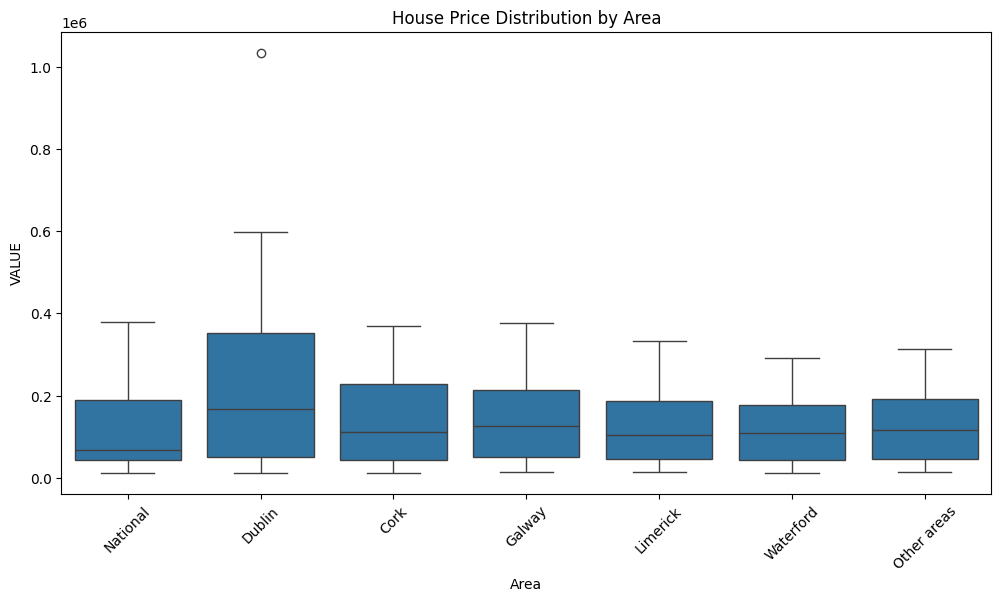

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Area', y='VALUE', data=combined_data)
plt.title('House Price Distribution by Area')
plt.xticks(rotation=45)
plt.show()

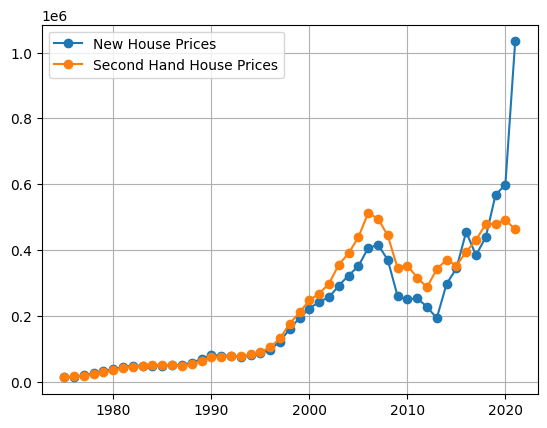

In [25]:
#Checking the Dublin data
dublin_data = combined_data[combined_data['Area'] == 'Dublin']
for prop_type in dublin_data['Property Type'].unique():
    data = dublin_data[dublin_data['Property Type'] == prop_type]
    plt.plot(data['Year'], data['VALUE'], marker='o', label=prop_type)


plt.legend()
plt.grid(True)
plt.show()


In [26]:
combined_data.to_csv('combined_housing_data.csv', index=False)


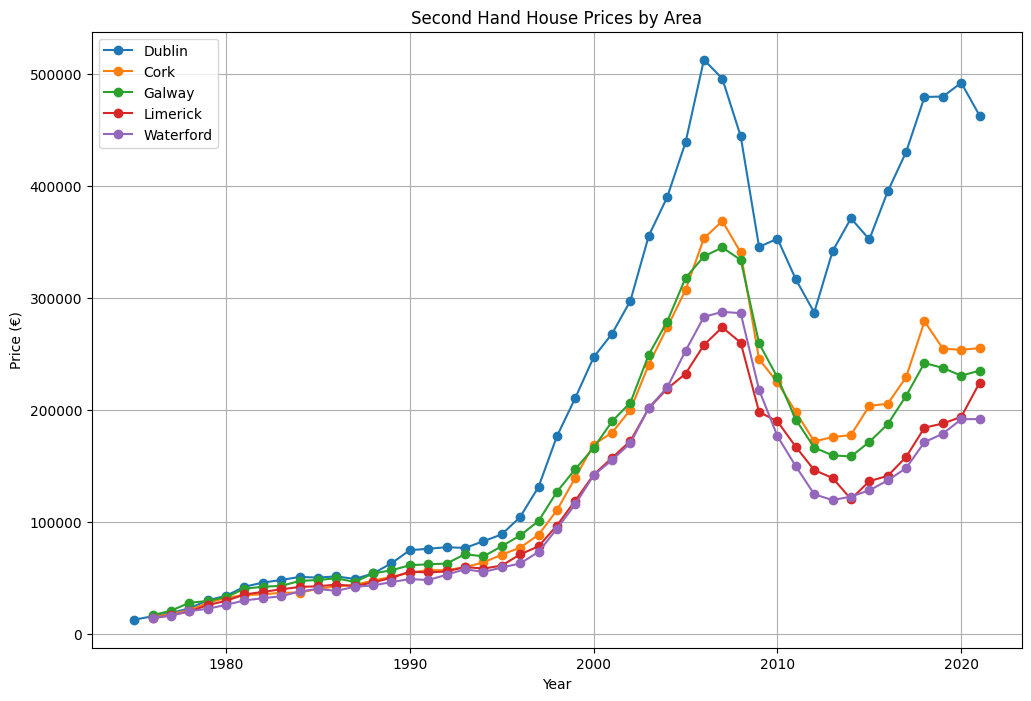

In [27]:
#Adding the data visualization for other counties

plt.figure(figsize=(12, 8))

for area in ['Dublin', 'Cork', 'Galway', 'Limerick', 'Waterford']:

    area_data = combined_data[(combined_data['Area'] == area) &

                              (combined_data['Property Type'] == 'Second Hand House Prices')]

    if not area_data.empty:

        plt.plot(area_data['Year'], area_data['VALUE'], marker='o', label=area)



plt.title('Second Hand House Prices by Area')

plt.xlabel('Year')

plt.ylabel('Price (€)')

plt.legend()

plt.grid(True)

plt.show()

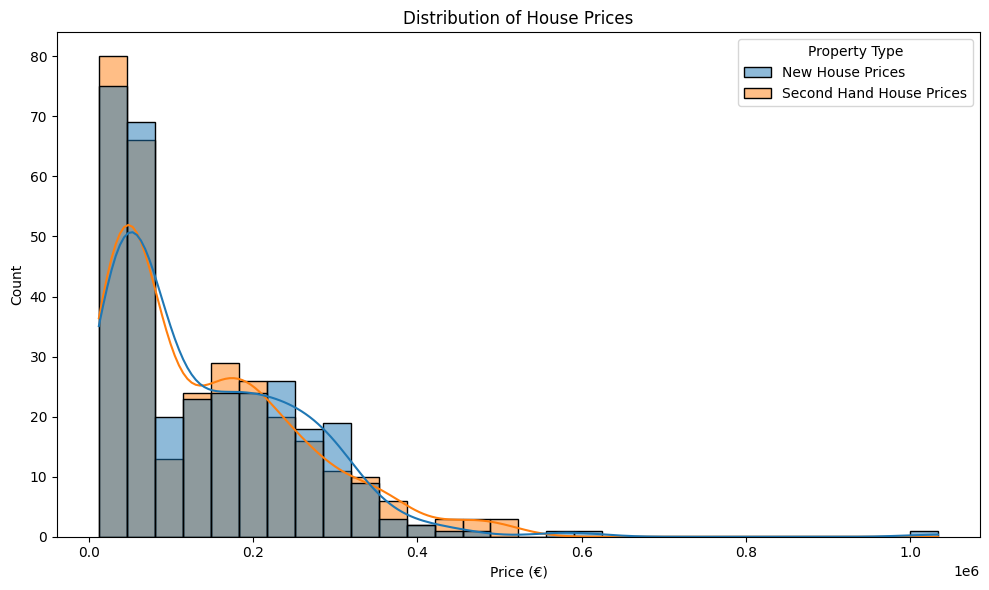

In [28]:
plt.figure(figsize=(10, 6))

sns.histplot(data=combined_data, x='VALUE', hue='Property Type', bins=30, kde=True)

plt.title('Distribution of House Prices')

plt.xlabel('Price (€)')

plt.ylabel('Count')

plt.tight_layout()

plt.show()





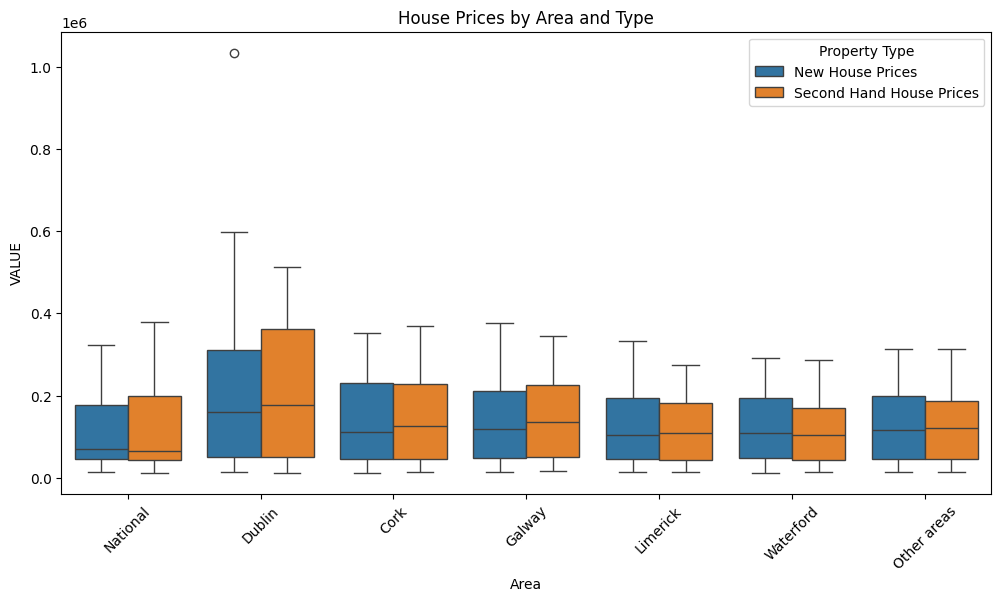

In [29]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=combined_data, x='Area', y='VALUE', hue='Property Type')

plt.title('House Prices by Area and Type')

plt.xticks(rotation=45)

plt.show()

In [30]:
combined_data = combined_data.dropna(subset=['VALUE'])

In [31]:
combined_data['Area_Code'] = pd.factorize(combined_data['Area'])[0]
combined_data['Property_Type_Code'] = pd.factorize(combined_data['Property Type'])[0]


X = combined_data[['Year', 'Area_Code', 'Property_Type_Code']]
y = combined_data['VALUE']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-31-e36f6d0434f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['Area_Code'] = pd.factorize(combined_data['Area'])[0]
<ipython-input-31-e36f6d0434f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['Property_Type_Code'] = pd.factorize(combined_data['Property Type'])[0]


In [32]:
X.shape, y.shape

((629, 3), (629,))

In [33]:
#Linear Regression
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = model.predict(X_test)

In [50]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
test_score = r2_score(y_test, y_pred)

Model Performance:
R² Score: 0.6767
RMSE: 58524.14


In [42]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2')
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

In [58]:
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
rf_grid.best_params_


rf_pred = rf_model.predict(X_test)
rf_test_r2 = rf_model.score(X_test, y_test)

In [44]:
#Neural network


nn_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}
nn_grid = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42), nn_params, cv=3, scoring='r2')
nn_grid.fit(X_train, y_train)
nn_model = nn_grid.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

In [55]:
nn_cv_scores = cross_val_score(nn_model, X, y, cv=5, scoring='r2')
nn_grid.best_params_


{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}

In [56]:
print("Performance Comparison:")
print(f"Linear Regression : {test_score:.4f}")
print(f"Random Forest : {rf_test_r2:.4f}")
print(f"Neural Network: {nn_test_r2:.4f}")



Test Set Performance Comparison:
Linear Regression : 0.6767
Random Forest : 0.9900
Neural Network: -0.0104
